# Building a Chatbot using Customer support on Twitter

## Source and Useful links

Get the data from: https://www.kaggle.com/thoughtvector/customer-support-on-twitter

Few useful blogs:
1. https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
2. https://colab.research.google.com/drive/1FKhOYhOz8d6BKLVVwL1YMlmoFQ2ML1DS#scrollTo=2zBmN8qB3O-e&forceEdit=true&offline=true&sandboxMode=true


## Buisness Problem

Chatbots are becoming more and more present in the lives of small and medium businesses. They are typically used as support for customer service, form-filling help, or treating large numbers of data. Chatbots are being made to ease the pain that the industries are facing today. However, today’s chatbots need to be intelligent, purposeful and accurate to survive.

Need to create a chatbot that can  understand the intent of a customer's request, query or complains and respond with accurate, precise information that has to be understood by the customer. It needs to understand the customer’s demands even when the sentence is complex. It has to be intelligent enough to predict what the customer is looking for.

## End Goal

Using Deep learning and NLP to make these chapbots intelligent and make them able to understand customers intenet most of the time.

There should be some other features that these chatbot should have, like: They should be accessible all the time, Can continue longer conversation and keep providing answers to customers, Flexible to work with many situation and industry and most important customer satisfaction.

Chatbots should reduce human dependecy and process large volume of requests for industry and customer interaction and by this way it can save more time and money with results with better productiviy for the industry.

## Performance Metrices
1. Categorical cross-entropy to train the model
2. BLEU score to check the translation

## Constraints:
1. Handling long and complex sentences
2. Quicker response time
3. Limitation of current NLP, to solve problems like mixing of local language and slangs

# Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Importing Libraries

In [ ]:
import pandas as pd  # For csv and dataframe
import numpy as np  # For array
import pickle  # To save an load data
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For plotting
from nltk.tokenize import word_tokenize  # Tokenizing sentences
from textblob import TextBlob  # To get sentence length
import re  # Regular expression
from prettytable import PrettyTable  # To print in a table

In [ ]:
import nltk
nltk.download('punkt') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Loading Data

In [ ]:
# Loading the data into dataframe
tweets_df = pd.read_csv('twcs.csv', encoding='utf-8')

In [ ]:
tweets_df.shape

(2811774, 7)

## Basic Information of the Data

In [ ]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [ ]:
tweets_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [ ]:
# Checking for Null values
tweets_df.isnull().sum()

tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64

## Creating Data with conversation

Create another dataset containing a client's initial request and the company's response.

In [ ]:
#Refer: https://www.kaggle.com/snocco/textpreprocessing-on-twitter

#first inbound = Richiesta iniziale di un cliente
first_inbound = tweets_df[pd.isnull(tweets_df.in_response_to_tweet_id) & tweets_df.inbound]

inbOutb = pd.merge(first_inbound, tweets_df, left_on='tweet_id', right_on='in_response_to_tweet_id').sample(frac=1)

# Filter to only outbound replies (from companies)
inbOutb = inbOutb[inbOutb.inbound_y ^ True]

In [ ]:
inbOutb.shape

(794299, 14)

In [ ]:
inbOutb.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
835252,2857369,219549,True,Mon Nov 27 21:29:50 +0000 2017,Hi @Uber_Support you told me someone would rin...,2857367,NaN,2857367,Uber_Support,False,Mon Nov 27 21:38:12 +0000 2017,@219549 So sorry to hear about your experience...,2857368,2857369.0
256832,946310,334373,True,Fri Oct 13 23:56:10 +0000 2017,Once again @UPSHelp you failed to provide the ...,"946309,946311",NaN,946309,UPSHelp,False,Sat Oct 14 00:41:58 +0000 2017,@334373 Let us know how we can assist you. Cli...,NaN,946310.0
159957,597276,261613,True,Sun Dec 03 19:49:30 +0000 2017,"@Uber_Support hello, how do you go about using...",597274,NaN,597274,Uber_Support,False,Sun Dec 03 19:54:33 +0000 2017,@261613 Hi there! Please reach out to https://...,597275,597276.0
625185,2170370,636682,True,Thu Nov 09 04:34:23 +0000 2017,Thought I would be lazy and use @116057 for di...,2170369,NaN,2170369,Postmates_Help,False,Thu Nov 09 04:36:11 +0000 2017,"@636682 Hi, DM us with any questions or concer...",NaN,2170370.0
99591,380842,206322,True,Mon Oct 09 08:01:46 +0000 2017,"@British_Airways hey morning BA, any contact i...",380841,NaN,380841,British_Airways,False,Mon Oct 09 09:18:37 +0000 2017,"@206322 We're unable to advise, Naresh. Please...",NaN,380842.0


text_x: Customers initial request, text_y: Companies response

In [ ]:
inbOutb.isnull().sum()

tweet_id_x                        0
author_id_x                       0
inbound_x                         0
created_at_x                      0
text_x                            0
response_tweet_id_x               0
in_response_to_tweet_id_x    794299
tweet_id_y                        0
author_id_y                       0
inbound_y                         0
created_at_y                      0
text_y                            0
response_tweet_id_y          530528
in_response_to_tweet_id_y         0
dtype: int64

In [ ]:
# Selecting only important colmns
data = inbOutb[['author_id_x', 'created_at_x', 'text_x', 'author_id_y', 'created_at_y', 'text_y']]

In [ ]:
data.shape

(794299, 6)

In [ ]:
data.head()

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
0,717257,Wed Nov 15 23:38:05 +0000 2017,@ATT might be nice to let your customers know ...,ATT,Wed Nov 15 23:51:43 +0000 2017,"@717257 Hey, Ryan! We don't want you to be exp..."
1,537020,Wed Oct 11 17:45:31 +0000 2017,love this! @537021 https://t.co/scTOz3hg8M,SouthwestAir,Wed Oct 11 17:49:47 +0000 2017,@537020 Thanks Denise! Just goes to show if yo...
2,414098,Wed Oct 25 22:43:52 +0000 2017,@British_Airways I need to transfer my avios p...,British_Airways,Thu Oct 26 06:18:53 +0000 2017,"@414098 Hi Kate, the nominated head of the hou..."
3,430610,Fri Oct 27 12:46:24 +0000 2017,@VirginTrains stuck in Euston. Will tickets be...,VirginTrains,Fri Oct 27 12:58:16 +0000 2017,@430610 We are awaiting an update as to when t...
4,318852,Fri Oct 13 01:51:40 +0000 2017,@Uber_Support how can I delete the only one cr...,Uber_Support,Fri Oct 13 08:18:54 +0000 2017,"@318852 Hey Vincent, you can find out how to r..."


In [ ]:
# Renaming columns
data = data.rename(columns={'text_x':'question', 'text_y':'answer'})

In [ ]:
data.shape

(794299, 6)

In [ ]:
# Saving to disk
pickle.dump(data, open('data_conv.pkl', 'wb'))

In [ ]:
# Loading from disk
data = pickle.load(open('data_conv.pkl', 'rb'))

In [ ]:
data.shape

(794299, 6)

In [ ]:
data.head()

,author_id_x,created_at_x,question,author_id_y,created_at_y,answer
251468,340004,Sat Oct 21 13:37:43 +0000 2017,@122172 need help,ATVIAssist,Sat Oct 21 14:21:21 +0000 2017,@340004 Hi. What's your platform &amp; which c...
700147,693750,Tue Nov 14 16:46:49 +0000 2017,@115911 @TMobileHelp @115725 @ATT @115911 why ...,TMobileHelp,Tue Nov 14 16:50:00 +0000 2017,@693750 Hey thanks so much for reaching out! Y...
185503,284249,Thu Nov 23 13:33:12 +0000 2017,Oh course @115955 WiFi would go down on Thanks...,Ask_Spectrum,Thu Nov 23 13:48:06 +0000 2017,@284249 I'm sorry to hear about the service is...
870280,820001,Thu Nov 30 01:17:45 +0000 2017,When the vinaigrette from @ChipotleTweets is 1...,ChipotleTweets,Thu Nov 30 01:21:30 +0000 2017,@820001 Sorry to hear that. Did you let a mana...
424733,476849,Sat Nov 04 00:12:43 +0000 2017,PISSED OFF THAT @115888 FUCKING CHARGED ME FUL...,SpotifyCares,Sat Nov 04 01:28:45 +0000 2017,@476849 Hi! We've just sent a DM your way. Let...


## EDA on Data

Checking tweets count by Company

In [ ]:
# Plot top 50 frequent company
keep_col = list(data['author_id_y'].value_counts()[:50].index)

In [ ]:
# Except for top 50 company replacing all with "others"
data['companies'] = data['author_id_y'].apply(lambda x:x if x in keep_col else 'others')

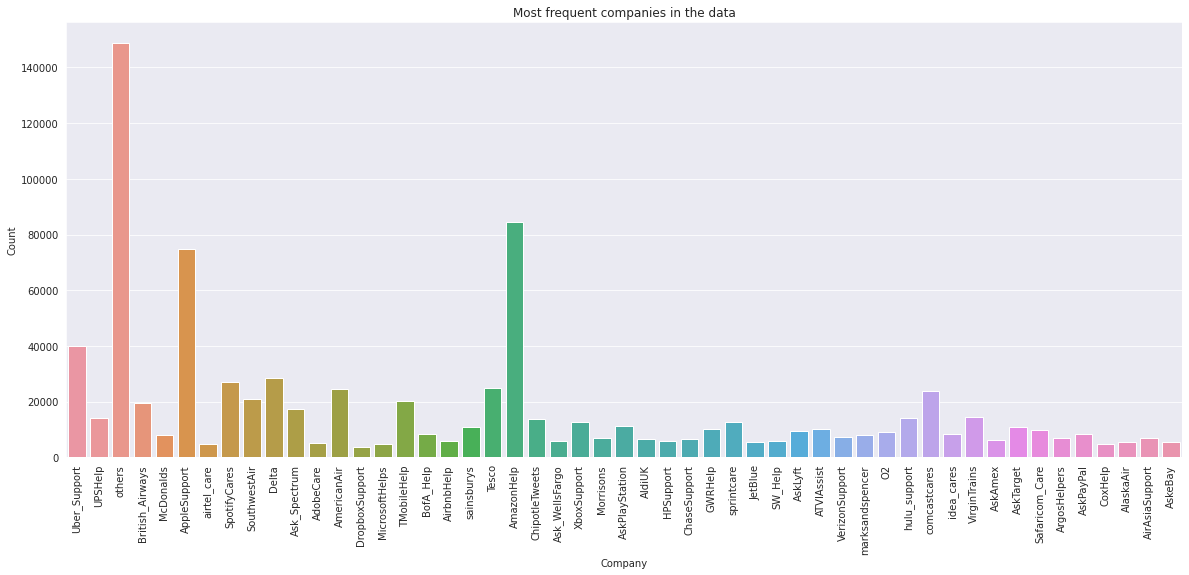

In [ ]:
# Plot of number of tweets by each company
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.countplot(x='companies', data=data)
plt.title("Most frequent companies in the data")
plt.xlabel("Company")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Utility function

#---------------------------------------------------------------
# Basic stats
#---------------------------------------------------------------
def basic_statistics (columns, data=data):
    """
    Return basic statistics like min, max and others
    """
    x = PrettyTable()
    header = ["stats"] + columns
    result = {'minimum':[], 'maximum':[], 'mean':[], 'median':[], '25th per':[],
              '50th per':[], '75th per':[], '90th per':[], '95th per':[], '99th per':[]}

    for col in columns:
        col_val = data[col].values
        # Getting stats for the column
        result['minimum'].append(np.round(col_val.min(),2))
        result['maximum'].append(np.round(col_val.max(),2))
        result['mean'].append(np.round(np.mean(col_val),2))
        result['median'].append(np.round(np.median(col_val),2))
        for p in [25, 50, 75, 90, 95, 99]:
            result[str(p)+"th per"].append(np.round(np.percentile(col_val, p),2))
    
    # Printing results in a table
    x.field_names = header
    for tup in result.items():
        x.add_row([tup[0]]+tup[1])
    print(x)



#---------------------------------------------------------------
# Plotting Series
#---------------------------------------------------------------
def plot_func(columns, xlabel, ylabel, title, data=data, header=["Question", "Answer"]):
    """
    Plots pdf and boxplot on the given data
    """
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(18, 6))
    
    # Adding subplots
    pdf = fig.add_subplot(1,2,1)
    box = fig.add_subplot(1,2,2)
    
    # pdf/distplot
    pdf.set(title=title, xlabel=xlabel, ylabel=ylabel)
    for col in columns:
        sns.distplot(data[col].values, hist=True, rug=True, ax=pdf, label=col)
    pdf.legend()
    
    # boxplot
    box.set(title=title, ylabel=xlabel)
    sns.boxplot(data=data[columns], ax=box, orient='v')
    box.set_xticklabels(columns)
    
    plt.plot()

### No of sentences in Text

Checking for number of sentectes in Questions and Answers

In [ ]:
# Sentences in question
data['qsn_len'] = data['question'].astype('str').apply(lambda x:len(TextBlob(x).sentences))

In [ ]:
# No of sentences in answer
data['ans_len'] = data['answer'].astype('str').apply(lambda x:len(TextBlob(x).sentences))

In [ ]:
basic_statistics(['qsn_len', 'ans_len'])

+----------+---------+---------+
|  stats   | qsn_len | ans_len |
+----------+---------+---------+
| minimum  |    1    |    1    |
| maximum  |   107   |    11   |
|   mean   |   2.05  |   2.67  |
|  median  |   2.0   |   3.0   |
| 25th per |   1.0   |   2.0   |
| 50th per |   2.0   |   3.0   |
| 75th per |   3.0   |   3.0   |
| 90th per |   3.0   |   4.0   |
| 95th per |   4.0   |   4.0   |
| 99th per |   5.0   |   5.0   |
+----------+---------+---------+


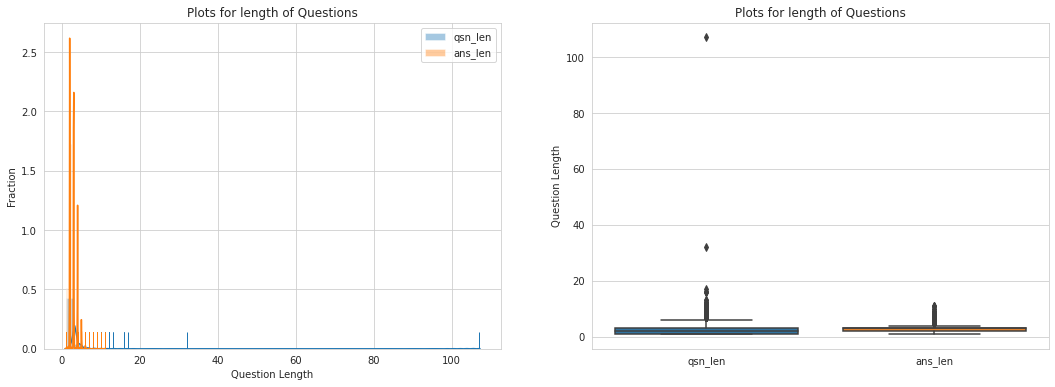

In [ ]:
plot_func(['qsn_len', 'ans_len'], 'Question Length', 'Fraction', 'Plots for length of Questions')

Questions:
1. No of sentences in questions starts from 1 to 107.
2. Most of text has less than 5 sentences. That is 99% percentile of rows has 5 or less sentences.
3. Few lines have 107 sentence, that's unusual. But as the data is restricted to 140 words we don't need to worry much abou that.

Answers:
1. In answer No of sent starts from 1 to 11.
2. Most of the lines has less than 5 sentences
3. Max no of sentence is also 11. That's normal.

### Count of words present in Text
Number of words present in the text. Checking in questions and answers how many words they are consists with.

In [ ]:
# Word counts in question
data['qsn_words'] = data['question'].astype('str').apply(lambda x: len(x.strip().split()))

# Word counts in answer
data['ans_words'] = data['answer'].astype('str').apply(lambda x: len(x.strip().split()))

In [ ]:
basic_statistics(['qsn_words', 'ans_words'])

+----------+-----------+-----------+
|  stats   | qsn_words | ans_words |
+----------+-----------+-----------+
| minimum  |     1     |     1     |
| maximum  |    112    |     66    |
|   mean   |   20.38   |   20.68   |
|  median  |    20.0   |    20.0   |
| 25th per |    14.0   |    16.0   |
| 50th per |    20.0   |    20.0   |
| 75th per |    25.0   |    24.0   |
| 90th per |    32.0   |    29.0   |
| 95th per |    40.0   |    36.0   |
| 99th per |    51.0   |    47.0   |
+----------+-----------+-----------+


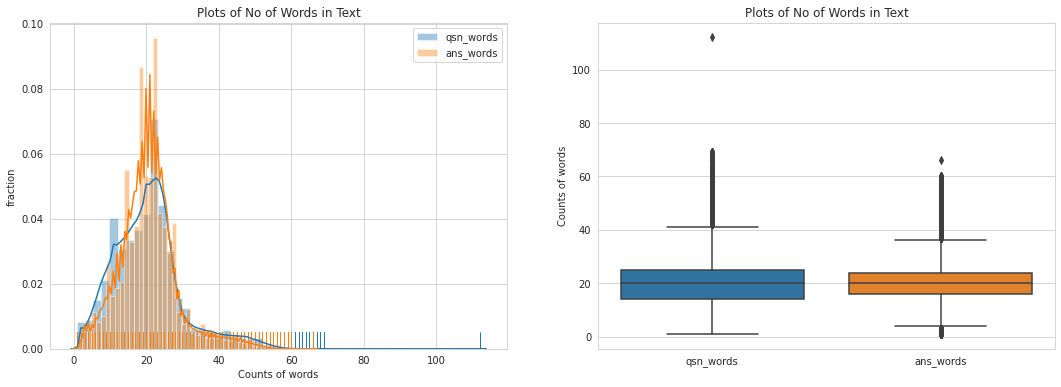

In [ ]:
plot_func(['qsn_words', 'ans_words'], 'Counts of words', 'fraction', 'Plots of No of Words in Text')

Questions:
1. Min value of count is 1, that means 1 word in the line.
2. Max word is 112. The sentence consist of small small charecters
3. Most of the lines are having word count less than 50
4. In pdf we can see the value lies between 0 to 60 words in a line. IQR 14-24

Answers:
1. Min value is 1 and max is 66. We can observe that answer column is lots more sensible than question column.
2. Most of the lines have values less than 46 words.
3. In pdf most 0-50 words have high percentage of occurance.
4. IQR value is 14-24. Same as 'question'. So both the data are somewhat similar in structure.

### Number of mentions (words starting with '@')

In [ ]:
data['qsn_mention'] = data['question'].apply(lambda x: len(re.findall(r"@\S+", x)))
data['ans_mention'] = data['answer'].apply(lambda x: len(re.findall(r"@\S+", x)))

In [ ]:
data['qsn_mention'].value_counts()

1     637766
2      90761
0      40925
3      17524
4       4729
5       1522
6        565
7        232
8        117
9         60
10        39
11        24
12         8
14         8
13         6
16         6
17         2
24         1
15         1
19         1
22         1
25         1
Name: qsn_mention, dtype: int64

In [ ]:
data['ans_mention'].value_counts()

1     770347
2      21320
3       1863
4        392
5        158
6         70
7         48
11        27
9         23
10        22
8         19
12         4
16         3
15         2
14         1
Name: ans_mention, dtype: int64

In [ ]:
basic_statistics(['qsn_mention', 'ans_mention'])

+----------+-------------+-------------+
|  stats   | qsn_mention | ans_mention |
+----------+-------------+-------------+
| minimum  |      0      |      1      |
| maximum  |      25     |      16     |
|   mean   |     1.14    |     1.04    |
|  median  |     1.0     |     1.0     |
| 25th per |     1.0     |     1.0     |
| 50th per |     1.0     |     1.0     |
| 75th per |     1.0     |     1.0     |
| 90th per |     2.0     |     1.0     |
| 95th per |     2.0     |     1.0     |
| 99th per |     3.0     |     2.0     |
+----------+-------------+-------------+


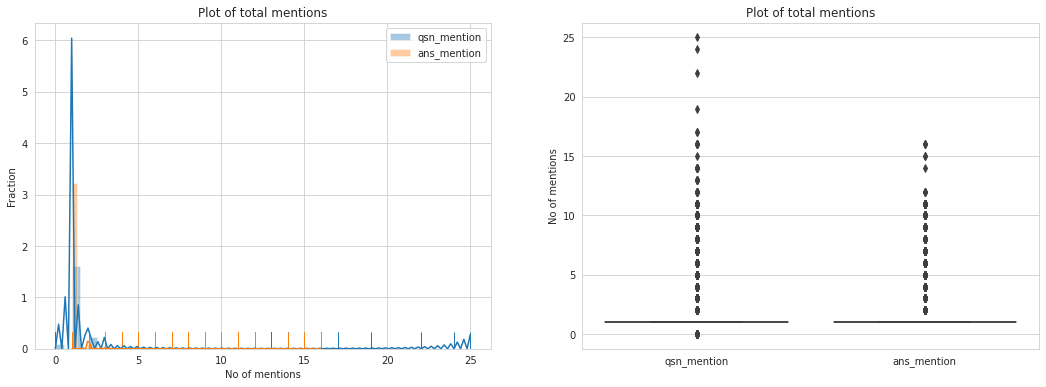

In [ ]:
plot_func(['qsn_mention', 'ans_mention'], 'No of mentions', 'Fraction', 'Plot of total mentions')

Questions:
1. Maximum number of mentions in question is 25 and of answer its 16
2. Generally users use more mentions than customer executive.
3. This mentions are not adding any meaning to the text, so we will remove all the mentions and userid from text.

### Number of words with '#'

In [ ]:
data['qsn_hashtag'] = data['question'].apply(lambda x: len(re.findall(r"#\S+", x)))
data['ans_hashtag'] = data['answer'].apply(lambda x: len(re.findall(r"#\S+", x)))

In [ ]:
data['qsn_hashtag'].value_counts()

0     675960
1      75424
2      27016
3       9658
4       3453
5       1455
6        643
7        322
8        163
9         79
10        41
11        31
12        17
13         9
14         8
15         5
16         4
17         4
19         4
18         3
Name: qsn_hashtag, dtype: int64

In [ ]:
data['ans_hashtag'].value_counts()

0    779888
1     13389
2       947
3        63
6         7
4         4
5         1
Name: ans_hashtag, dtype: int64

In [ ]:
basic_statistics(['qsn_hashtag', 'ans_hashtag'])

+----------+-------------+-------------+
|  stats   | qsn_hashtag | ans_hashtag |
+----------+-------------+-------------+
| minimum  |      0      |      0      |
| maximum  |      19     |      6      |
|   mean   |     0.24    |     0.02    |
|  median  |     0.0     |     0.0     |
| 25th per |     0.0     |     0.0     |
| 50th per |     0.0     |     0.0     |
| 75th per |     0.0     |     0.0     |
| 90th per |     1.0     |     0.0     |
| 95th per |     2.0     |     0.0     |
| 99th per |     3.0     |     1.0     |
+----------+-------------+-------------+


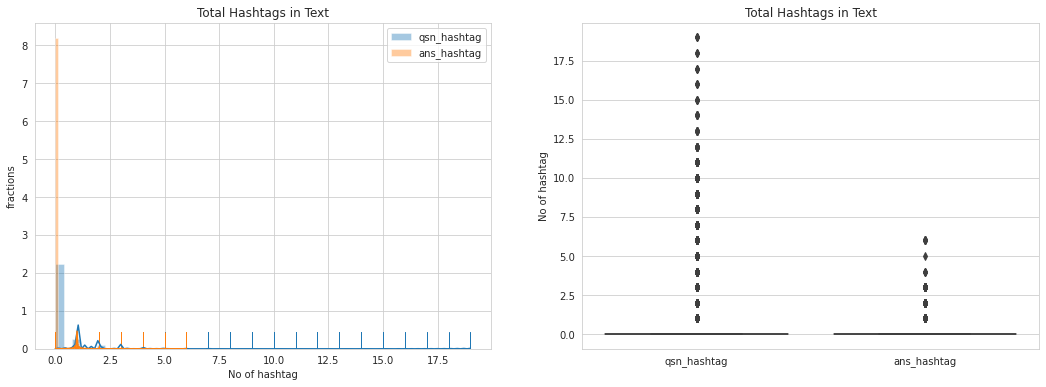

In [ ]:
plot_func(['qsn_hashtag', 'ans_hashtag'], 'No of hashtag', 'fractions', 'Total Hashtags in Text')

1. Maximum value found in questions is 19 and in answers 6
2. Use of hashtags are little less than use of mentions in twitter.
3. But there are some people who tweets using only hashtag words and putting hashtags befor all of the words in their tweets.
4. So we will not remove hashtags words, as they are generally part of the conversation and have some meaning.

In [ ]:
data[data['qsn_hashtag']>=15]

,author_id_x,created_at_x,question,author_id_y,created_at_y,answer,qsn_len,ans_len,qsn_words,ans_words,qsn_mention,ans_mention,qsn_hashtag,ans_hashtag
124826,228561,Fri Dec 01 09:04:58 +0000 2017,"Hong Kong, No.5\nPersonal Project\n@British_Ai...",British_Airways,Fri Dec 01 12:03:15 +0000 2017,"@228561 Thanks for sharing these with us, Chri...",1,3,23,21,1,1,16,0
143384,246040,Sat Dec 02 13:18:38 +0000 2017,Takeoff onboard @British_Airways @116705 #b767...,British_Airways,Sat Dec 02 15:51:45 +0000 2017,"@246040 Enjoy the flight, Dan! ^Paul",1,2,26,6,3,1,17,0
785180,756978,Sun Nov 19 16:08:07 +0000 2017,A very #chocolatey #glutenfree #dessert @75652...,Tesco,Sun Nov 19 17:19:43 +0000 2017,@756978 Looks absolutely stunning 😍🤯 We bet it...,3,1,39,16,2,1,15,0
699754,693411,Tue Nov 14 14:37:03 +0000 2017,Come fly with me! Where would you like to go n...,British_Airways,Tue Nov 14 16:55:50 +0000 2017,"@693411 @2532 Thanks for your lovely post, Tho...",3,3,33,21,3,2,17,0
618141,433449,Wed Nov 08 20:30:27 +0000 2017,#Flying to @141317 from @193789 on @SouthwestA...,SouthwestAir,Wed Nov 08 20:34:05 +0000 2017,@433449 It's always a pleasure to have you onb...,3,3,29,17,6,1,18,0
122849,226764,Fri Dec 01 01:51:59 +0000 2017,I received my new mini cards today. ❤️ Thank y...,MOO,Fri Dec 01 02:26:39 +0000 2017,@226764 Beautiful! Thanks so much for sharing! :),5,3,32,8,1,1,16,0
848721,520008,Tue Nov 28 18:39:47 +0000 2017,A hazy morning while coming in for a landing. ...,Delta,Tue Nov 28 18:41:01 +0000 2017,"@520008 Hi Adam, that photo is absolutely gorg...",3,3,34,15,2,1,19,0
662849,665423,Sun Nov 12 09:31:55 +0000 2017,"#AmazonPrime, 2 #commandes dans la #semaine &a...",AmazonHelp,Sun Nov 12 09:37:52 +0000 2017,"@665423 Bonjour, désolée d'apprendre cela :/ q...",5,2,30,18,0,1,19,0
842780,228561,Tue Nov 28 08:22:29 +0000 2017,"Hong Kong, No.2\n@British_Airways \nPersonal P...",British_Airways,Tue Nov 28 09:44:10 +0000 2017,"@228561 Thanks for sharing, Chris! We hope to ...",1,3,24,14,1,1,17,0
631890,641576,Thu Oct 19 13:28:31 +0000 2017,#One #good #reason #not #to #close #your #wind...,AmericanAir,Thu Oct 19 13:30:02 +0000 2017,@641576 We're glad you kept your shade up. Thi...,3,2,21,13,3,1,16,0


In [ ]:
data.shape

(794299, 14)

Common hashtags in text:
1. Just checking Tweets with common hashtags in question and answer.
2. There are not many sentences with atleast 1 common hashtag

In [ ]:
for ind,row in data[data['ans_hashtag']>=3].iterrows():
    q = set(re.findall(r"#\S+", row['question']))
    a = set(re.findall(r"#\S+", row['answer']))
    if (q.intersection(a)):
        print(q.intersection(a))

{'#AAElevate'}
{'#SomosLIVE'}
{'#GoCougs'}
{'#3'}
{'#MVP'}
{'#iFlyAlaska'}
